In [4]:
from typing import List, Tuple
from ibapi.client import *
from ibapi.wrapper import *
import datetime as dt
import numpy as np
import time
import threading
import matplotlib.pyplot as plt

port = 7496


class TestApp(EClient, EWrapper):
    times: List[dt.date] = []
    values: List[float] = []
    window_size: int = 0

    def __init__(self):
        EClient.__init__(self, self)
        self.window_size = 252  # Size of the moving window for z-score calculation

    def nextValidId(self, orderId: OrderId):
        self.orderId = orderId

    def nextId(self):
        self.orderId += 1
        return self.orderId

    def error(self, reqId, errorCode, errorString, advancedOrderReject=""):
        print(f"reqId: {reqId}, errorCode: {errorCode}, errorString: {errorString}, orderReject: {advancedOrderReject}")

    def historicalData(self, reqId, bar: BarData):
        date_obj = dt.datetime.strptime(bar.date, '%Y%m%d')
        self.times.append(date_obj)
        self.values.append(bar.close)
        print(reqId, bar)

    def historicalDataEnd(self, reqId, start, end):
        print(f"Historical Data Ended for {reqId}. Started at {start}, ending at {end}")
        self.cancelHistoricalData(reqId)

    def calculate_moving_z_score(self) -> np.ndarray:
        """Calculate moving z-score using rolling window"""
        z_scores = np.zeros(len(self.values))

        for i in range(len(self.values)):
            start_idx = max(0, i - self.window_size + 1)
            window = self.values[start_idx:(i + 1)]

            if len(window) >= 2:  # Need at least 2 points to calculate std
                window_mean = np.mean(window)
                window_std = np.std(window)
                if window_std != 0:
                    z_scores[i] = (self.values[i] - window_mean) / window_std

        return z_scores

    def plot_data(self):
        if len(self.values) < 2:
            print("Not enough data to plot")
            return

        # Convert to numpy arrays
        values_array = np.array(self.values)

        # Calculate global z-score
        global_mean = np.mean(values_array)
        global_std = np.std(values_array)
        global_z_scores = (values_array - global_mean) / global_std

        # Calculate moving z-score
        moving_z_scores = self.calculate_moving_z_score()

        # Create figure with three subplots sharing x-axis
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

        # Plot original time series
        ax1.plot(self.times, values_array, 'b-', label='Original Values')
        ax1.axhline(y=global_mean, color='r', linestyle='--', alpha=0.3, label='Global Mean')
        ax1.set_ylabel('Original Values')
        ax1.set_title('Time Series Data')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot global z-scores
        ax2.plot(self.times, global_z_scores, 'g-', label='Global Z-Score')
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        ax2.set_ylabel('Global Z-Score')
        ax2.set_title(f'Global Z-Scores')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot moving z-scores
        ax3.plot(self.times, moving_z_scores, 'm-', label=f'Moving Z-Score (window={self.window_size})')
        ax3.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        ax3.set_ylabel('Moving Z-Score')
        ax3.set_title(f'Moving Z-Scores (Window Size: {self.window_size})')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        # Print some statistics
        print("Global Statistics:")
        print(f"Mean: {global_mean:.2f}")
        print(f"Standard deviation: {global_std:.2f}")
        print(f"Max global z-score: {np.max(global_z_scores):.2f}")
        print(f"Min global z-score: {np.min(global_z_scores):.2f}")

        print("\nMoving Window Statistics:")
        print(f"Max moving z-score: {np.max(moving_z_scores):.2f}")
        print(f"Min moving z-score: {np.min(moving_z_scores):.2f}")

    def get_current_stats(self) -> Tuple[float, float]:
        """Returns current mean and standard deviation"""
        if not self.values:
            return 0.0, 0.0
        values_array = np.array(self.values)
        return np.mean(values_array), np.std(values_array)

app = TestApp()
app.connect("127.0.0.1", port, 26)
threading.Thread(target=app.run).start()
time.sleep(1)

contract = Contract()
contract.symbol = "2828"
contract.secType = "STK"
contract.exchange = "SEHK"
contract.currency = "HKD"

app.reqHistoricalData(app.nextId(), contract, "20250624-00:00:00", "10 Y", "1 day", "TRADES", 1, 1, False, [])
#time.sleep(10)



reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:uscrypto, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:usbond, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:usfarm.nj, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:hfarm, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:eufarm, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:jfarm, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:cashfarm, orderReject: 
reqId: -1, errorCode: 2104, errorString: Market data farm connection is OK:usfarm, orderReject: 
reqId: -1, errorCode: 2106, errorString: HMDS data farm connection is OK:apachmds, orderReject: 
reqId: -1, errorCode: 2106, errorString: HMDS data farm connection is OK:cashhmds, orderReject: 
reqId: -1, errorCode: 210

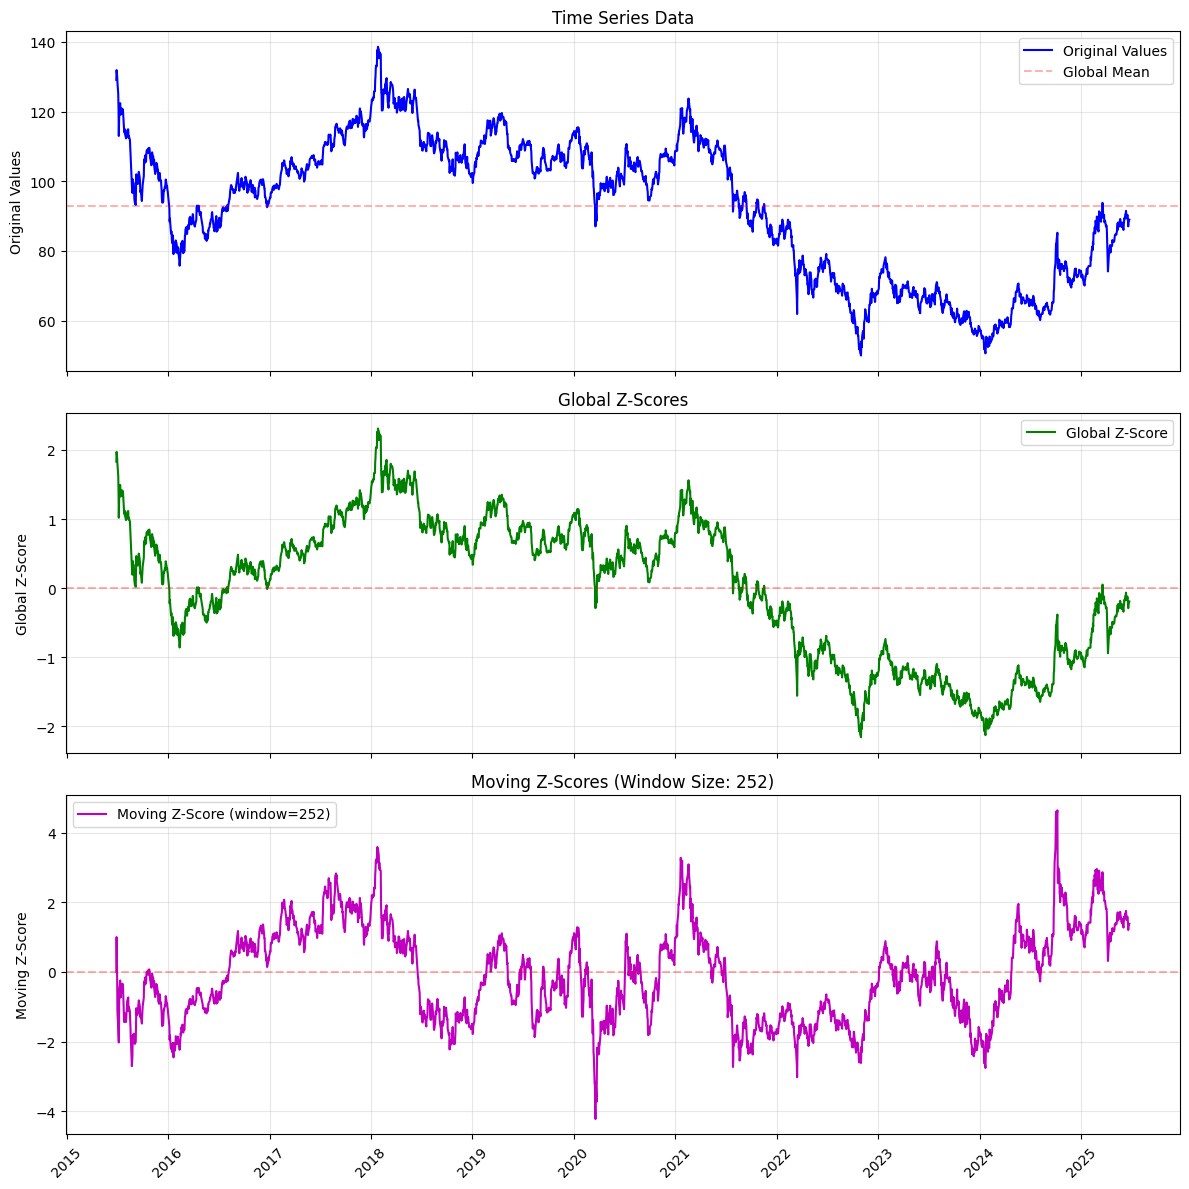

Global Statistics:
Mean: 92.79
Standard deviation: 19.83
Max global z-score: 2.31
Min global z-score: -2.16

Moving Window Statistics:
Max moving z-score: 4.64
Min moving z-score: -4.22


In [5]:
import matplotlib.pyplot as plt
app.calculate_moving_z_score()
app.plot_data()
app.disconnect()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate z-score
mean = np.mean(values)
std = np.std(values)
z_scores = (values - mean) / std

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot original time series
ax1.plot(time, values, 'b-', label='Original Values')
ax1.axhline(y=mean, color='r', linestyle='--', alpha=0.3, label='Mean')
ax1.set_ylabel('Original Values')
ax1.set_title('Time Series Data')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot z-scores
ax2.plot(time, z_scores, 'g-', label='Z-Score')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='Z=0')
ax2.set_ylabel('Z-Score')
ax2.set_title('Z-Scores Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print some statistics
print("Mean of the data:", mean)
print("Standard deviation:", std)
print("Max z-score:", np.max(z_scores))
print("Min z-score:", np.min(z_scores))